<a href="https://colab.research.google.com/github/ibitoladgr8/Machine-Learning/blob/main/HFT_signal_Generation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [ ]:
train_df = pd.read_csv('order_book_data.csv')
train_df.shape

(399, 5)

In [ ]:
train_df.head()

,position,operation,side,price,size
0,0,0,Ask,3301.55,350
1,1,0,Ask,3301.53,100
2,2,0,Ask,3301.49,100
3,3,0,Ask,3301.46,100
4,4,0,Ask,3301.44,1000


In [ ]:
train_df['price'].max()

3302.48

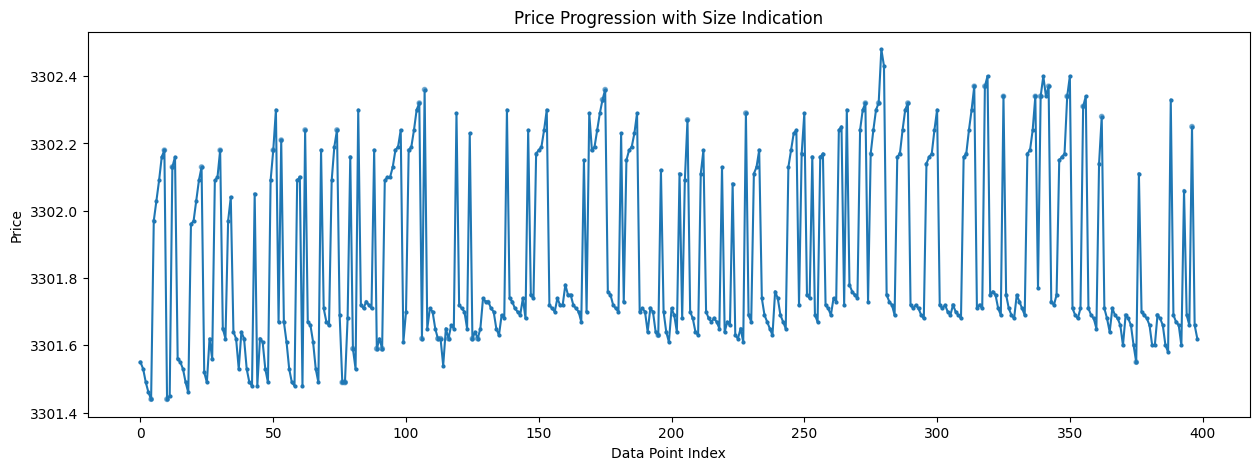

In [ ]:
    plt.figure(figsize=(15, 5))
    plt.plot(train_df.index, train_df['price'], marker='o', linestyle='-', markersize=2) # Basic price plot
    plt.scatter(train_df.index, train_df['price'], s=train_df['size']/100, alpha=0.5) # Scatter plot with size as marker size
    plt.title('Price Progression with Size Indication')
    plt.xlabel('Data Point Index')
    plt.ylabel('Price')
    plt.show()

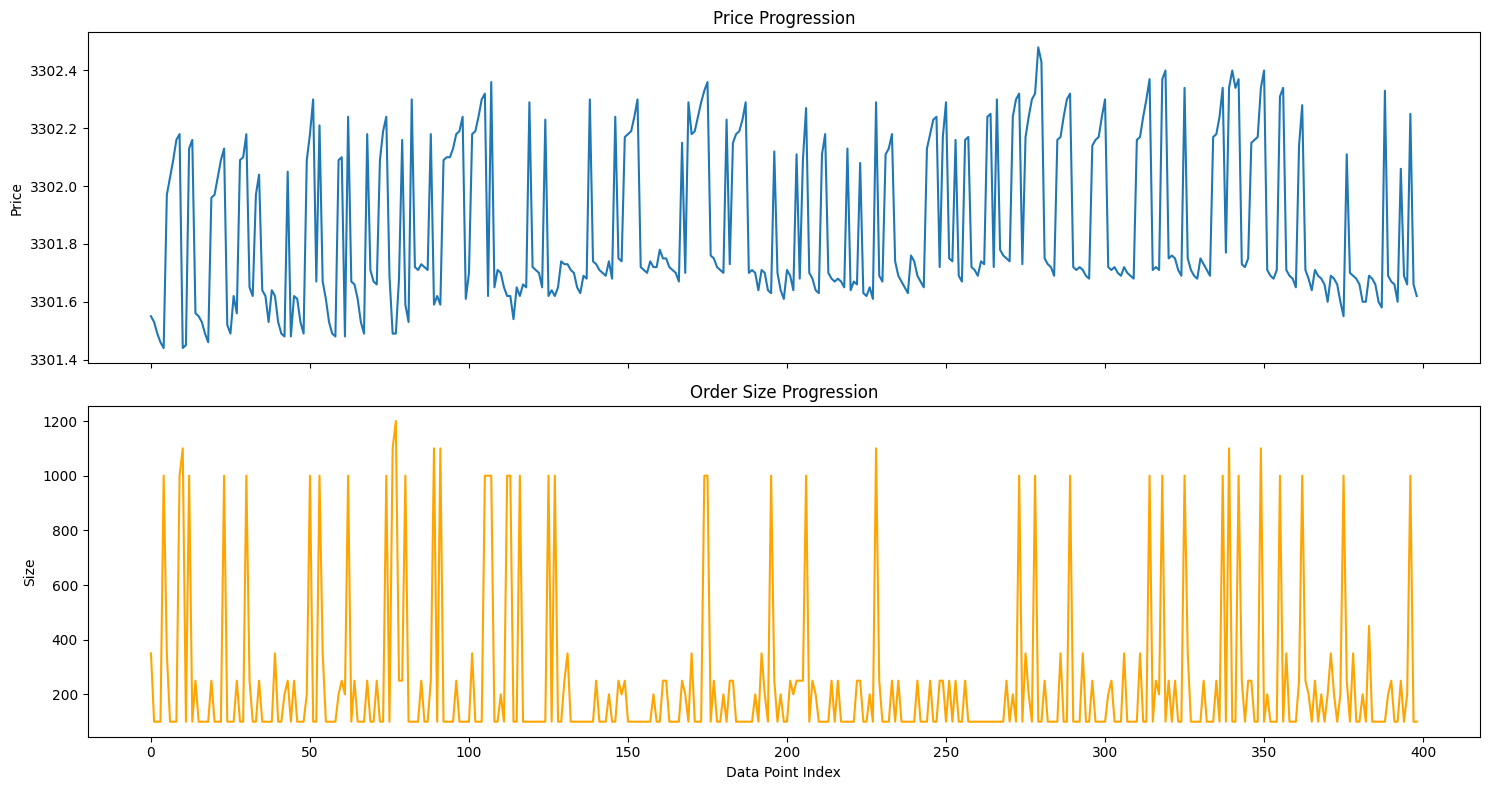

In [ ]:
    fig, axes = plt.subplots(2, 1, figsize=(15, 8), sharex=True)

    # Price plot
    axes[0].plot(train_df.index, train_df['price'])
    axes[0].set_title('Price Progression')
    axes[0].set_ylabel('Price')

    # Size plot
    axes[1].plot(train_df.index, train_df['size'], color='orange')
    axes[1].set_title('Order Size Progression')
    axes[1].set_xlabel('Data Point Index')
    axes[1].set_ylabel('Size')

    plt.tight_layout()
    plt.show()

In [ ]:
train_df.dtypes

,0
position,int64
operation,int64
side,object
price,float64
size,int64


In [ ]:

# Compute features: OFI, mid-price, volatility
def compute_features(df, vol_window=10):
    # Order Flow Imbalance (OFI)
    df['bid_volume_change'] = 0.0
    df['ask_volume_change'] = 0.0
    for i in range(len(df)):
        row = df.iloc[i]
        if row['position'] == 0:  # Only consider best bid/ask
            if row['side'] == 'Bid':
                df.at[i, 'bid_volume_change'] = row['size'] if row['operation'] == 0 else -row['size']
            elif row['side'] == 'Ask':
                df.at[i, 'ask_volume_change'] = row['size'] if row['operation'] == 0 else -row['size']

    df['bid_volume_change_sum'] = df['bid_volume_change'].cumsum()
    df['ask_volume_change_sum'] = df['ask_volume_change'].cumsum()
    df['ofi'] = np.where((df['bid_volume_change_sum'] + df['ask_volume_change_sum']) != 0,
                         (df['bid_volume_change_sum'] - df['ask_volume_change_sum']) /
                         (df['bid_volume_change_sum'] + df['ask_volume_change_sum']),
                         0)

    # Mid-price and volatility
    df['mid_price'] = np.nan
    last_bid = np.nan
    last_ask = np.nan
    for i in range(len(df)):
        row = df.iloc[i]
        if row['position'] == 0:
            if row['side'] == 'Bid':
                last_bid = row['price']
            elif row['side'] == 'Ask':
                last_ask = row['price']
        if not np.isnan(last_bid) and not np.isnan(last_ask):
            df.at[i, 'mid_price'] = (last_bid + last_ask) / 2
        elif not np.isnan(last_bid):
            df.at[i, 'mid_price'] = last_bid
        elif not np.isnan(last_ask):
            df.at[i, 'mid_price'] = last_ask
        else:
            df.at[i, 'mid_price'] = df['mid_price'].mean()

    df['returns'] = df['mid_price'].pct_change().fillna(0)
    df['volatility'] = df['returns'].rolling(window=vol_window).std().fillna(0) * np.sqrt(252)

    return df

In [ ]:
def plot_features(df):
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 12))

    # Mid-price
    mid_price_data = df[df['mid_price'].notna()][['time_idx', 'mid_price']].drop_duplicates()
    ax1.plot(mid_price_data['time_idx'], mid_price_data['mid_price'], color='blue')
    ax1.set_title('Mid-Price Over Time')
    ax1.set_xlabel('Time Index')
    ax1.set_ylabel('Mid-Price')
    ax1.grid(True)

    # OFI
    ax2.fill_between(df['time_idx'], df['ofi'], color='green', alpha=0.3)
    ax2.set_title('Order Flow Imbalance (OFI)')
    ax2.set_xlabel('Time Index')
    ax2.set_ylabel('OFI')
    ax2.set_ylim(-1, 1)
    ax2.grid(True)

    # Volatility
    volatility_data = df[df['volatility'].notna()][['time_idx', 'volatility']].drop_duplicates()
    ax3.plot(volatility_data['time_idx'], volatility_data['volatility'], color='red')
    ax3.set_title('Volatility (Annualized)')
    ax3.set_xlabel('Time Index')
    ax3.set_ylabel('Volatility')
    ax3.grid(True)

    plt.tight_layout()
    plt.show()

In [ ]:
def engineer_hft_features(df):
    df = compute_features(df)

    # Print sample of results
    print("\nSample Feature Results:")
    print(df[['side', 'position', 'operation', 'size', 'ofi', 'mid_price', 'volatility']].head(10))

    # Print summary statistics
    print("\nFeature Statistics:")
    print(df[['ofi', 'mid_price', 'volatility']].describe())

    # Plot features
    #plot_features(df)

    return df

In [ ]:
engineer_hft_features(train_df)


Sample Feature Results:
  side  position  operation  size  ofi  mid_price  volatility
0  Ask         0          0   350 -1.0    3301.55    0.000000
1  Ask         1          0   100 -1.0    3301.55    0.000000
2  Ask         2          0   100 -1.0    3301.55    0.000000
3  Ask         3          0   100 -1.0    3301.55    0.000000
4  Ask         4          0  1000 -1.0    3301.55    0.000000
5  Bid         0          0   350  0.0    3301.76    0.000000
6  Bid         1          0   100  0.0    3301.76    0.000000
7  Bid         2          0   100  0.0    3301.76    0.000000
8  Bid         3          0   100  0.0    3301.76    0.000000
9  Bid         4          0  1000  0.0    3301.76    0.000319

Feature Statistics:
              ofi    mid_price  volatility
count  399.000000   399.000000  399.000000
mean    -0.296645  3301.910627    0.000024
std      0.423606     0.075635    0.000041
min     -2.333333  3301.550000    0.000000
25%     -0.499878  3301.875000    0.000008
50%     -0.129

,position,operation,side,price,size,bid_volume_change,ask_volume_change,bid_volume_change_sum,ask_volume_change_sum,ofi,mid_price,returns,volatility
0,0,0,Ask,3301.55,350,0.0,350.0,0.0,350.0,-1.000000,3301.550,0.0,0.000000
1,1,0,Ask,3301.53,100,0.0,0.0,0.0,350.0,-1.000000,3301.550,0.0,0.000000
2,2,0,Ask,3301.49,100,0.0,0.0,0.0,350.0,-1.000000,3301.550,0.0,0.000000
3,3,0,Ask,3301.46,100,0.0,0.0,0.0,350.0,-1.000000,3301.550,0.0,0.000000
4,4,0,Ask,3301.44,1000,0.0,0.0,0.0,350.0,-1.000000,3301.550,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
394,0,1,Ask,3301.69,100,0.0,-100.0,-4900.0,-5350.0,-0.043902,3301.875,0.0,0.000038
395,3,1,Ask,3301.66,200,0.0,0.0,-4900.0,-5350.0,-0.043902,3301.875,0.0,0.000038
396,3,1,Bid,3302.25,1000,0.0,0.0,-4900.0,-5350.0,-0.043902,3301.875,0.0,0.000038
397,3,1,Ask,3301.66,100,0.0,0.0,-4900.0,-5350.0,-0.043902,3301.875,0.0,0.000038


In [ ]:
train_df.shape

(399, 13)

In [ ]:
from gym import Env
from gym.spaces import Box, Discrete
#import torch

In [ ]:
#not using this cell

def add_additional_features(df, vol_window=3):
    df['mid_price'] = np.nan
    df['volatility'] = 0.0

    last_bid = np.nan
    last_ask = np.nan

    for i in range(len(df)):
        row = df.iloc[i]
        if row['position'] == 0:
            if row['side'] == 'Bid':
                last_bid = row['price']
            elif row['side'] == 'Ask':
                last_ask = row['price']
        if not np.isnan(last_bid) and not np.isnan(last_ask):
            df.at[i, 'mid_price'] = (last_bid + last_ask) / 2
        elif not np.isnan(last_bid):
            df.at[i, 'mid_price'] = last_bid
        elif not np.isnan(last_ask):
            df.at[i, 'mid_price'] = last_ask
        else:
            df.at[i, 'mid_price'] = df['mid_price'].mean()

    df['returns'] = df['mid_price'].pct_change().fillna(0)
    df['volatility'] = df['returns'].rolling(window=vol_window).std().fillna(0) * np.sqrt(252)

    return df

In [ ]:
def prepare_rl_data(df, lookback=10, price_scale=3301.55):
    states = []
    for t in range(lookback, len(df)):
        window = df.iloc[t-lookback:t]
        bid_data = window[window['side'] == 'Bid'].sort_values('position').head(10)
        ask_data = window[window['side'] == 'Ask'].sort_values('position').head(10)

        bid_prices = np.zeros(10)
        bid_sizes = np.zeros(10)
        ask_prices = np.zeros(10)
        ask_sizes = np.zeros(10)

        for i in range(min(10, len(bid_data))):
            bid_prices[i] = bid_data.iloc[i]['price'] / price_scale
            bid_sizes[i] = bid_data.iloc[i]['size']
        for i in range(min(10, len(ask_data))):
            ask_prices[i] = ask_data.iloc[i]['price'] / price_scale
            ask_sizes[i] = ask_data.iloc[i]['size']

        features = df.iloc[t][['ofi', 'mid_price', 'volatility']].values
        if np.isnan(features[1]):
            features[1] = price_scale
        features[1] = features[1] / price_scale  # Normalize mid_price for state
        if np.isnan(features[2]):
            features[2] = 0.0

        state = np.concatenate([bid_prices, bid_sizes, ask_prices, ask_sizes, features])
        states.append(state)

    return np.array(states)

In [ ]:
class HFTEnv(Env):
    def __init__(self, states, df, lookback=10, trade_size=100, reward_scale=10):
        super(HFTEnv, self).__init__()
        self.states = states
        self.df = df  # Store DataFrame to access raw mid_price
        self.current_step = 0
        self.max_steps = len(states) - 1
        self.lookback = lookback
        self.trade_size = trade_size  # Increased trade size
        self.reward_scale = reward_scale  # Scale reward for visibility
        self.max_position = 20000
        self.observation_space = Box(low=-np.inf, high=np.inf, shape=(43,), dtype=np.float32)
        self.action_space = Discrete(4)  # 0: hold, 1: buy, 2: sell, 3: cancel

        self.position = 0
        self.cash = 100000000  # Increased to handle larger trades
        self.portfolio_value = self.cash
        self.reward_mean = 0  # For reward normalization
        self.reward_std = 1  # For reward normalization
        self.reward_count = 0  # For reward normalization
        self.alpha = 0.01

    def reset(self):
        self.current_step = 0
        self.position = 0
        self.cash = 100000000
        self.portfolio_value = self.cash
        return self.states[self.current_step]

    def step(self, action):
      current_idx = self.current_step + self.lookback
      mid_price = self.df.iloc[current_idx]['mid_price']
      if np.isnan(mid_price):
        mid_price = 3301.55

      volatility = self.df.iloc[current_idx]['volatility'] if not np.isnan(self.df.iloc[current_idx]['volatility']) else 0.0

      reward = 0
      previous_value = self.portfolio_value
      transaction_cost = 0.00001 * self.trade_size * mid_price

      if action == 1:  # Buy
        cost = mid_price * self.trade_size
        if self.cash >= cost and self.position + self.trade_size <= self.max_position:
            self.position += self.trade_size
            self.cash -= cost
            reward -= transaction_cost
            print(f"Buy: Cost={cost:.2f}, New Cash={self.cash:.2f}, Position={self.position}")
      elif action == 2:  # Sell
        revenue = mid_price * self.trade_size
        if self.position >= self.trade_size:
            self.position -= self.trade_size
            self.cash += revenue
            reward -= transaction_cost
            print(f"Sell: Revenue={revenue:.2f}, New Cash={self.cash:.2f}, Position={self.position}")
      elif action == 3:  # Cancel
        if self.position != 0:
            liquidation_value = self.position * mid_price
            self.cash += liquidation_value
            self.position = 0
            reward -= transaction_cost
            print(f"Cancel: Liquidation={liquidation_value:.2f}, New Cash={self.cash:.2f}, Position={self.position}")

      self.portfolio_value = self.cash + self.position * mid_price

    # Sharpe-like reward
      portfolio_change = self.portfolio_value - previous_value
      if volatility > 0:
        raw_reward = (portfolio_change / (volatility * mid_price)) * self.reward_scale - transaction_cost
      else:
        raw_reward = (portfolio_change / mid_price) * self.reward_scale - transaction_cost

    # Normalize reward
      self.reward_count += 1
      if self.reward_count == 1:
        self.reward_mean = raw_reward
        self.reward_std = 1
      else:
        old_mean = self.reward_mean
        self.reward_mean = (1 - self.alpha) * self.reward_mean + self.alpha * raw_reward
        self.reward_std = np.sqrt((1 - self.alpha) * self.reward_std**2 + self.alpha * (raw_reward - old_mean)**2)

      if self.reward_std > 0:
        reward = (raw_reward - self.reward_mean) / self.reward_std
      else:
        reward = raw_reward

      self.current_step += 1
      done = self.current_step >= self.max_steps
      next_state = self.states[self.current_step] if not done else np.zeros(self.observation_space.shape)
      return next_state, reward, done, {}

In [ ]:
train_df.shape

(399, 13)

In [ ]:
#train_df = add_additional_features(train_df)
states = prepare_rl_data(train_df)
train_df.shape, states

((399, 13),
 array([[1.0001272129757235, 1.0001453862579697, 1.0001635595402159, ...,
         np.float64(0.0), np.float64(1.0000636064878619),
         np.float64(0.0003193020349334381)],
        [1.0001272129757235, 1.0001453862579697, 1.0001635595402159, ...,
         np.float64(0.0), np.float64(1.0000636064878619),
         np.float64(0.0003193020349334381)],
        [1.0001272129757235, 1.0001453862579697, 1.0001635595402159, ...,
         np.float64(0.0), np.float64(1.0000636064878619),
         np.float64(0.0003193020349334381)],
        ...,
        [1.0001544728990928, 1.0002362526692008, 0.0, ...,
         np.float64(-0.04390243902439024), np.float64(1.000098438612167),
         np.float64(3.8008117744627734e-05)],
        [1.0001544728990928, 1.0002120216262058, 1.0002362526692008, ...,
         np.float64(-0.04390243902439024), np.float64(1.000098438612167),
         np.float64(3.8008117744627734e-05)],
        [1.0001544728990928, 1.0002120216262058, 1.0002362526692008, ..

In [ ]:
# Load and preprocess data
#train_df = pd.read_csv('order_book_data.csv')

#states = prepare_rl_data(train_df)

# Create and test the environment
env = HFTEnv(states, train_df, trade_size=1000, reward_scale=10)
state = env.reset()
done = False
while not done:
    action = env.action_space.sample()  # Random action for testing
    next_state, reward, done, _ = env.step(action)
    print(f"Step: {env.current_step}, Action: {action}, Reward: {reward:.2f}, Portfolio Value: {env.portfolio_value:.2f}")

Step: 1, Action: 2, Reward: 0.00, Portfolio Value: 100000000.00
Step: 2, Action: 0, Reward: 0.00, Portfolio Value: 100000000.00
Buy: Cost=3301760.00, New Cash=96698240.00, Position=1000
Step: 3, Action: 1, Reward: 0.00, Portfolio Value: 100000000.00
Cancel: Liquidation=3301760.00, New Cash=100000000.00, Position=0
Step: 4, Action: 3, Reward: 0.00, Portfolio Value: 100000000.00
Step: 5, Action: 0, Reward: -0.00, Portfolio Value: 100000000.00
Buy: Cost=3301765.00, New Cash=96698235.00, Position=1000
Step: 6, Action: 1, Reward: -0.00, Portfolio Value: 100000000.00
Cancel: Liquidation=3301765.00, New Cash=100000000.00, Position=0
Step: 7, Action: 3, Reward: -0.00, Portfolio Value: 100000000.00
Buy: Cost=3301765.00, New Cash=96698235.00, Position=1000
Step: 8, Action: 1, Reward: -0.00, Portfolio Value: 100000000.00
Buy: Cost=3301765.00, New Cash=93396470.00, Position=2000
Step: 9, Action: 1, Reward: -0.00, Portfolio Value: 100000000.00
Sell: Revenue=3301760.00, New Cash=96698230.00, Positio

In [ ]:
!pip install stable-baselines3


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.5/184.5 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 93.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 79.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 46.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 84.0 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalli

In [ ]:
#!pip install shimmy

from stable_baselines3 import PPO
model = PPO("MlpPolicy", env, verbose=1)
model.learn(total_timesteps=10000)


Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 388      |
|    ep_rew_mean     | -1.67    |
| time/              |          |
|    fps             | 830      |
|    iterations      | 1        |
|    time_elapsed    | 2        |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 388         |
|    ep_rew_mean          | -1.67       |
| time/                   |             |
|    fps                  | 594         |
|    iterations           | 2           |
|    time_elapsed         | 6           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.009225147 |
|    clip_fraction        | 0.0651      |
|    clip_range           | 0.2         |
|    entropy_loss   